In [2]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time


# Inicializa navegador
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://contexto.me/en/")

print("🔄 Carregando BERT...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Embeddings cache
embeddings = {}
memory = {}

🔄 Carregando BERT...


In [ ]:
# Palavras genéricas para abrir sentidos semânticos
temas_exploratorios = [
    "object", "place", "person", "animal", "emotion",
    "food", "vehicle", "technology", "family", "music",
    "clothing", "tool", "plant", "profession", "color"
]
temas_usados = set()


In [45]:
# Função para obter e adicionar embedding
def get_embedding(word):
    if word in embeddings:
        return embeddings[word]

    with torch.no_grad():
        inputs = tokenizer(word, return_tensors="en", truncation=True)
        inputs = {k: v for k, v in inputs.items()}
        outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings[word] = emb
        return emb

# Adiciona chute manual
def adicionar_chute(palavra, score):
    print(f"📥 Chute registrado: '{palavra}' com score {score}")
    memory[palavra] = score
    get_embedding(palavra)

# Sugestão adaptativa
def sugerir_proximo():
    print("\n🎯 Gerando nova sugestão...")

    if not memory:
        sugestao = random.choice(temas_exploratorios)
        temas_usados.add(sugestao)
        print(f"🧭 Começando exploração: {sugestao}")
        return sugestao

    # Classificação refinada por score
    perfeitos = [(p, s) for p, s in memory.items() if s < 50]
    otimos    = [(p, s) for p, s in memory.items() if 50 <= s < 200]
    bons      = [(p, s) for p, s in memory.items() if 200 <= s < 300]
    oks       = [(p, s) for p, s in memory.items() if 300 <= s < 500]
    ruins     = [(p, s) for p, s in memory.items() if s >= 500]

    todos_ruins = len(ruins) == len(memory)

    if todos_ruins:
        restantes = [t for t in temas_exploratorios if t not in temas_usados]
        if restantes:
            sugestao = random.choice(restantes)
            temas_usados.add(sugestao)
            print(f"🔍 Todos os chutes estão ruins. Explorando novo tema: {sugestao}")
            return sugestao
        else:
            print("⚠️ Todos os temas exploratórios já foram usados. Chutando palavra genérica aleatória.")
            return random.choice([w for w in tokenizer.vocab.keys() if w.isalpha() and len(w) > 4 and w not in memory])

    # Refinamento inteligente com prioridade por nível
    base = []

    if len(perfeitos) >= 1:
        base = sorted(perfeitos, key=lambda x: x[1])  # usa todos
        print(f"💥 Refinando a partir de perfeitos ({len(base)}): {[p for p, _ in base]}")
    elif len(otimos) >= 1:
        base = sorted(otimos, key=lambda x: x[1])
        print(f"🌟 Refinando a partir de ótimos ({len(base)}): {[p for p, _ in base]}")

    elif len(bons) >= 1:
        base = sorted(bons, key=lambda x: x[1])
        print(f"👌 Refinando a partir de bons ({len(base)}): {[p for p, _ in base]}")

    elif len(oks) >= 1:
        base = sorted(oks, key=lambda x: x[1])
        print(f"🙂 Refinando a partir de oks ({len(base)}): {[p for p, _ in base]}")
    else:
        base = sorted(memory.items(), key=lambda x: x[1])[:2]
        print(f"🤔 Refinando com os menos ruins: {[p for p, _ in base]}")

    # Cálculo do vetor médio com pesos
    vetores = np.array([get_embedding(p) for p, _ in base])
    pesos = np.array([1 / (s + 1) for _, s in base])
    pesos = pesos / pesos.sum()
    vetor_medio = np.average(vetores, axis=0, weights=pesos)

    # Seleção de candidatos
    candidatos = [w for w in tokenizer.vocab.keys() if w.isalpha() and len(w) > 4 and w not in memory]
    random.shuffle(candidatos)
    candidatos = candidatos[:1000]

    melhor_palavra = None
    melhor_sim = -1
    for w in candidatos:
        vec = get_embedding(w)
        sim = cosine_similarity([vetor_medio], [vec])[0][0]
        if sim > melhor_sim:
            melhor_sim = sim
            melhor_palavra = w

    print(f"✅ Próxima sugestão: {melhor_palavra} (sim={melhor_sim:.4f})")
    return melhor_palavra

def enviar_chute_site(palavra):
    # Preenche o campo
    input_box = driver.find_element(By.CSS_SELECTOR, "input.word")
    input_box.clear()
    input_box.send_keys(palavra)
    input_box.send_keys(Keys.ENTER)

    # Aguarda resposta
    time.sleep(1.5)

    # Verifica se apareceu a mensagem de palavra repetida
    try:
        msg_box = driver.find_element(By.CSS_SELECTOR, ".message-text")
        if "already guessed" in msg_box.text:
            print(f"⚠️ Palavra já testada: {palavra}")
            return palavra, None  # Ignorar
    except:
        pass  # nenhuma mensagem = segue normal

    # Lê o chute mais recente
    try:
        resultado = driver.find_element(By.CSS_SELECTOR, ".row-wrapper.current .row")
        texto = resultado.text.strip()
        palavra_retornada, score = texto.split()
        return palavra_retornada.lower(), int(score)
    except Exception as e:
        print("⚠️ Erro ao tentar ler o resultado:", e)
        return palavra, None

def reenviar_chutes_para_interface():
    print("\n📤 Reenviando chutes manuais para a interface do jogo...")
    for palavra in list(memory.keys()):
        _, score_checado = enviar_chute_site(palavra)  # reenviar no site e confirmar score real
        print(f"🔁 {palavra} → confirmado no site com score {score_checado}")

def adicionar_chute_site(palavra):
    print(f"\n📤 Enviando chute direto: '{palavra}'")
    chute, score = enviar_chute_site(palavra)

    if score is None:
        print(f"⏭️ Ignorado: '{chute}' não retornou score (talvez repetido ou erro).")
        return

    memory[chute] = score
    get_embedding(chute)
    print(f"📥 Registrado: '{chute}' com score {score}")


In [46]:
time.sleep(10)
def loop_automatico():
    reenviar_chutes_para_interface()

    while True:
        proxima = sugerir_proximo()
        chute, score = enviar_chute_site(proxima)
        
        if score is not None:
            adicionar_chute(chute, score)
        else:
            print("⏭️ Ignorando chute inválido ou repetido.")

        if score == 0:
            print("🎉 Palavra secreta encontrada:", chute)
            break


In [10]:
listaPalavras = ["place", "chefs", "richest", "subcontinent", "intention", "originate", "arthritis", "person", "knicks", "deadline"]

if len(listaPalavras) != 0:
    print("⚠️ Nenhuma palavra foi passada para o loop automático.") 
    for palavra in listaPalavras:
        adicionar_chute_site(palavra)
else:
    print("🔄 Iniciando jogo")
loop_automatico()


⚠️ Nenhuma palavra foi passada para o loop automático.

📤 Enviando chute direto: 'place'
📥 Registrado: 'chef' com score 5609

📤 Enviando chute direto: 'chefs'
📥 Registrado: 'chef' com score 5609

📤 Enviando chute direto: 'richest'
📥 Registrado: 'chef' com score 5609

📤 Enviando chute direto: 'subcontinent'
⚠️ Palavra já testada: subcontinent
⏭️ Ignorado: 'subcontinent' não retornou score (talvez repetido ou erro).

📤 Enviando chute direto: 'intention'
📥 Registrado: 'intention' com score 2679

📤 Enviando chute direto: 'originate'
📥 Registrado: 'originate' com score 5815

📤 Enviando chute direto: 'arthritis'
📥 Registrado: 'arthritis' com score 15189

📤 Enviando chute direto: 'person'
📥 Registrado: 'person' com score 878

📤 Enviando chute direto: 'knicks'
📥 Registrado: 'knicks' com score 5695

📤 Enviando chute direto: 'deadline'
📥 Registrado: 'deadline' com score 3741

📤 Reenviando chutes manuais para a interface do jogo...
⚠️ Palavra já testada: vehicle
🔁 vehicle → confirmado no site com

KeyboardInterrupt: 

['vehicle', 'emotion', 'family', 'plant', 'clothes', 'object', 'place', 'mascara', 'christian', 'stanley', 'freeze', 'witty', 'hubbard', 'layer', 'vowed', 'algebra', 'cornice', 'mcleod', 'revenge', 'lombard', 'largely', 'graveyard', 'platinum', 'smeared', 'electoral', 'pockets', 'camped', 'mccormick', 'supervisors', 'accession', 'negro', 'presidency', 'highlands', 'joaquin', 'spitfire', 'showcases', 'pieter', 'shine', 'weeks', 'reluctance', 'crashed', 'decree', 'distressed', 'methodist', 'harness', 'residence', 'application', 'testament', 'lectures', 'rouse', 'repeats', 'validity', 'verlag', 'furthermore', 'hanoi', 'aching', 'amplitude', 'enfield', 'complained', 'leagues', 'sport', 'wreck', 'melanie', 'securely', 'rated', 'musicals', 'towards', 'opportunities', 'yugoslavia', 'compatibility', 'redesigned', 'stephanie', 'stakeholders', 'style', 'cabin', 'muttering', 'sleepy', 'monster', 'homestead', 'shrill', 'hellenic', 'disadvantaged', 'assassination', 'belgarath', 'burial', 'extras', 

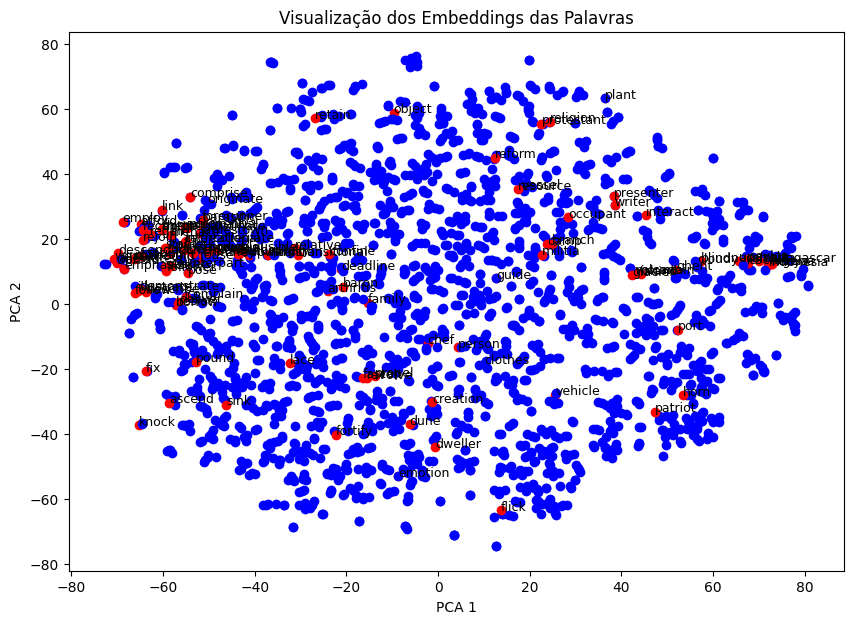

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Coleta embeddings e palavras
palavras = list(embeddings.keys())
print(palavras)
vetores = np.array([embeddings[p] for p in palavras])

# Reduz para 2D
pca = TSNE(n_components=2, perplexity=5)
vetores_2d = pca.fit_transform(vetores)

# Palavras já tentadas
tentadas = set(memory.keys())

# Plota
plt.figure(figsize=(10, 7))
for i, palavra in enumerate(palavras):
    if palavra in tentadas:
        cor = 'red' 
        plt.text(vetores_2d[i, 0], vetores_2d[i, 1], palavra, fontsize=9)
    else:
        cor = 'blue'
    plt.scatter(vetores_2d[i, 0], vetores_2d[i, 1], color=cor)

plt.title("Visualização dos Embeddings das Palavras")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [48]:
# for i, palavra in enumerate(palavras):
#     print(vetores_2d[i, 0], vetores_2d[i, 1], palavra)

palavra_mais_proxima = "link"

limite = 10.0
idx_ref = palavras.index(palavra_mais_proxima)
x_ref = vetores_2d[idx_ref, 0]
y_ref = vetores_2d[idx_ref, 1]

# palavras_proximas_x = []
# for j in range(len(palavras)):
#     if abs(vetores_2d[j, 0] - x_ref) <= limite:
#         palavras_proximas_x.append(palavras[j])
# print("Palavras próximas no eixo x:", palavras_proximas_x)

# palavras_proximas_y = []
# for j in range(len(palavras)):
#     if abs(vetores_2d[j, 1] - y_ref) <= limite:
#         palavras_proximas_y.append(palavras[j])
# print("Palavras próximas no eixo y:", palavras_proximas_y)

palavras_proximas_raio = []
for j in range(len(palavras)):
    if abs(vetores_2d[j, 0] - x_ref) <= limite and abs(vetores_2d[j, 1] - y_ref) <= limite:
        palavras_proximas_raio.append(palavras[j])
print("Palavras próximas no raio:", palavras_proximas_raio)
print("quantidade de palavras próximas:", len(palavras_proximas_raio))


Palavras próximas no raio: ['jamestown', 'menacing', 'revive', 'palatinate', 'championed', 'ported', 'afford', 'recreational', 'branching', 'linked', 'theta', 'originate', 'forerunner', 'hides', 'horned', 'employs', 'originating', 'regaining', 'employing', 'recaptured', 'revolves', 'flourished', 'minus', 'rejoined', 'comprised', 'constitute', 'intercollegiate', 'propelled', 'retains', 'parasitic', 'conceal', 'informally', 'exponential', 'recapture', 'comprise', 'menace', 'link', 'employ', 'regain', 'rejoin']
quantidade de palavras próximas: 40


In [49]:
for p in palavras_proximas_raio:
        adicionar_chute_site(p)



📤 Enviando chute direto: 'jamestown'


InvalidSessionIdException: Message: invalid session id: session deleted as the browser has closed the connection
from disconnected: not connected to DevTools
  (Session info: chrome=136.0.7103.114)
Stacktrace:
	GetHandleVerifier [0x0067FC03+61635]
	GetHandleVerifier [0x0067FC44+61700]
	(No symbol) [0x004A05D3]
	(No symbol) [0x0048FE20]
	(No symbol) [0x004ADD1F]
	(No symbol) [0x00513E8C]
	(No symbol) [0x0052DF19]
	(No symbol) [0x0050D096]
	(No symbol) [0x004DC840]
	(No symbol) [0x004DD6A4]
	GetHandleVerifier [0x00904523+2701795]
	GetHandleVerifier [0x008FFCA6+2683238]
	GetHandleVerifier [0x0091A9EE+2793134]
	GetHandleVerifier [0x006968C5+155013]
	GetHandleVerifier [0x0069CFAD+181357]
	GetHandleVerifier [0x00687458+92440]
	GetHandleVerifier [0x00687600+92864]
	GetHandleVerifier [0x00671FF0+5296]
	BaseThreadInitThunk [0x77145D49+25]
	RtlInitializeExceptionChain [0x7774D03B+107]
	RtlGetAppContainerNamedObjectPath [0x7774CFC1+561]
